In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import cv2
import shutil
import bcolz
import matplotlib.pyplot as plt
%matplotlib inline
# os.chdir('/home/f/dogbreed')
os.chdir('D:\Machine Learning\Kaggle\Dog Breed Identification')

In [3]:
augment_size = 1
learning_rate = 0.00003
batch_size_top = 4096
batch_size = 64

In [4]:
df_train = pd.read_csv('labels.csv')
df_test = pd.read_csv('sample_submission.csv',index_col=0)

targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)
num_classes = one_hot_labels.shape[1]
num_total_examples = one_hot_labels.shape[0]
dummy_labels = np.argmax(one_hot_labels,axis=1)
dummy_targets = np.asarray(targets_series)

targets_to_idx_dict = {}
idx_to_targets_dict = {}

for n,i in zip(dummy_targets,dummy_labels):
    targets_to_idx_dict[n] = i
    idx_to_targets_dict[i] = n

# for key in targets_to_idx_dict.keys():
#     os.mkdir('train/{}'.format(key))
    
# os.mkdir('val')
# for key in targets_to_idx_dict.keys():
#     os.mkdir('val/{}'.format(key))

# train_example_list = list(np.random.choice(range(num_total_examples),size=int(0.85*num_total_examples),replace=False))

# val_example_list = list(set(range(num_total_examples)) - set(train_example_list))

# for i in train_example_list:
#     shutil.move('train/' + df_train.iloc[i]['id'] + '.jpg', 'train/{}'.format(df_train.iloc[i]['breed']))

# for i in val_example_list:
#     shutil.move('train/' + df_train.iloc[i]['id'] + '.jpg', 'val/{}'.format(df_train.iloc[i]['breed']))

In [5]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.preprocessing import image

D:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def random_crop(image):
    """Crops a random region of width x height from image.
    Returns an image"""
    ratio = 0.8
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    crop_origin_x = np.random.randint(0, image.shape[0] - width)
    crop_origin_y = np.random.randint(0, image.shape[1] - height)
    cropped_image = image[crop_origin_y:crop_origin_y+height,crop_origin_x:crop_origin_x+width,:]
    cropped_image = cv2.resize(cropped_image,(image.shape[0],image.shape[1]))
    return cropped_image

In [6]:
batch_size = 512
datagen = ImageDataGenbatch_size = 512
datagen = ImageDataGenerator(rescale=1./255)
datagen_aug = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=random_crop,
                                   rotation_range=45,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
aug_generator = datagen_aug.flow_from_directory('train/',target_size=(360,360),batch_size=batch_size)
val_generator = datagen.flow_from_directory('val/',target_size=(360,360),batch_size=batch_size)
train_generator = datagen.flow_from_directory('train/',target_size=(360,360),batch_size=batch_size)
# steps_per_epoch = len(train_generator)erator(rescale=1./255)
# steps_per_epoch = len(train_generator)

Found 8688 images belonging to 120 classes.
Found 1534 images belonging to 120 classes.
Found 8688 images belonging to 120 classes.


In [18]:
input_img = Input(shape=(360,360,3))
# model_Xception = keras.applications.Xception(include_top=True,weights='imagenet',input_shape=(360,360,3),input_tensor=input_img)
model_Inception = keras.applications.InceptionV3(include_top=True,weights='imagenet',input_shape=(360,360,3),input_tensor=input_img)
# extracted_features = model_Xception.layers[-1].input
extracted_features = model_Inception.layers[-1].input
extraction_model = Model(inputs=input_img,outputs=extracted_features)

In [10]:
def features_extraction(gen,model,augment_size=1):
    x_bcolz,y_bcolz = None,None
    i = 0
    for x,y in gen:
        bottelneck_features = model.predict(x)
        if not x_bcolz:
            x_bcolz = bcolz.carray(bottelneck_features,bcolz.cparams(clevel=5),mode='w')
            y_bcolz = bcolz.carray(y,bcolz.cparams(clevel=5),mode='w')
        x_bcolz.append(bottelneck_features)
        y_bcolz.append(y)
        print('{} pieces generated'.format((i+1)*batch_size))
        if x_bcolz.shape[0] >= len(gen)*augment_size*batch_size:
            break
        i += 1
    return x_bcolz[:],y_bcolz[:]   

In [11]:
x_train,y_train = features_extraction(train_generator,extraction_model,1)

512 pieces generated
1024 pieces generated
1536 pieces generated
2048 pieces generated
2560 pieces generated
3072 pieces generated
3584 pieces generated
4096 pieces generated
4608 pieces generated
5120 pieces generated
5632 pieces generated
6144 pieces generated
6656 pieces generated
7168 pieces generated
7680 pieces generated
8192 pieces generated


In [12]:
x_val,y_val = features_extraction(val_generator,extraction_model,1)

512 pieces generated
1024 pieces generated


In [13]:
x_total = np.concatenate((x_train,x_val),axis=0)
y_total = np.concatenate((y_train,y_val),axis=0)  

In [14]:
np.save('x_total_incep',x_total)
np.save('y_total_incep',y_total)

In [12]:
x_total = np.load('bottleneck_data\\x_total_incep.npy')

In [13]:
y_total = np.load('bottleneck_data\\y_total_incep.npy')

In [14]:
def build_top_only_model(learning_rate):
    input_features = Input(shape=(2048,))
    out = Dense(units=120,activation='softmax',use_bias=True)(input_features)
    model_top = Model(inputs=input_features,outputs=out)
    model_top.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[keras.metrics.categorical_accuracy])
    return model_top

In [16]:
num_epochs_k_folds = 6000
all_acc_histories = []
all_loss_histories = []
k = 5

num_val_samples = len(x_total) // k
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_total[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_total[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_total = np.concatenate(
        [x_total[:i * num_val_samples],
         x_total[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_total = np.concatenate(
        [y_total[:i * num_val_samples],
         y_total[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_top_only_model(learning_rate)
    # Train the model (in silent mode, verbose=0)
    his = model.fit(partial_x_total, partial_y_total,epochs=num_epochs_k_folds,validation_data=(val_data, val_targets), batch_size=batch_size_top, verbose=0)
    val_acc_history = his.history['val_categorical_accuracy']
    all_acc_histories.append(val_acc_history)
    val_loss_history = his.history['val_loss']
    all_loss_histories.append(val_loss_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [17]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs_k_folds)]

In [18]:
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs_k_folds)]

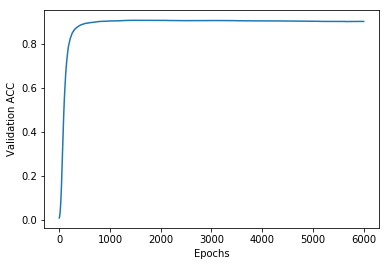

In [19]:
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation ACC')
plt.show()

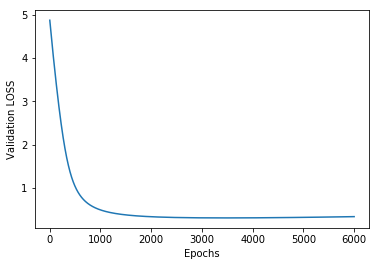

In [20]:
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.show()

In [21]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

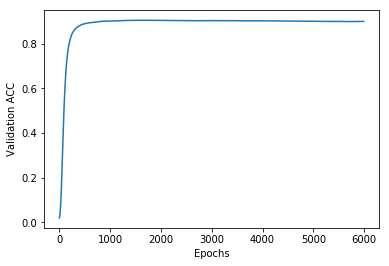

In [22]:
smooth_acc_history = smooth_curve(average_acc_history[10:])

plt.plot(range(1, len(smooth_acc_history) + 1), smooth_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation ACC')
plt.show()

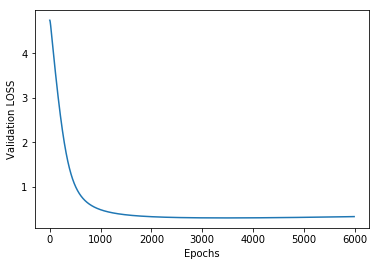

In [23]:
smooth_loss_history = smooth_curve(average_loss_history[10:])

plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.show()

In [24]:
np.argmin(np.array(average_loss_history))

3444

In [15]:
model_top = build_top_only_model(learning_rate)

In [17]:
his = model_top.fit(x = x_total,y = y_total,batch_size=batch_size_top, epochs=2000,verbose=1)

Epoch 1/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.8606 - categorical_accuracy: 0.00 - ETA: 0s - loss: 4.8628 - categorical_accuracy: 0.00 - 1s 70us/step - loss: 4.8615 - categorical_accuracy: 0.0088
Epoch 2/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.8407 - categorical_accuracy: 0.00 - ETA: 0s - loss: 4.8429 - categorical_accuracy: 0.00 - 0s 48us/step - loss: 4.8407 - categorical_accuracy: 0.0092
Epoch 3/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.8236 - categorical_accuracy: 0.00 - ETA: 0s - loss: 4.8211 - categorical_accuracy: 0.00 - 0s 48us/step - loss: 4.8203 - categorical_accuracy: 0.0099
Epoch 4/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.8050 - categorical_accuracy: 0.01 - ETA: 0s - loss: 4.8035 - categorical_accuracy: 0.01 - 1s 50us/step - loss: 4.8002 - categorical_accuracy: 0.0109
Epoch 5/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.7933 - categor

Epoch 37/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.1998 - categorical_accuracy: 0.25 - ETA: 0s - loss: 4.1982 - categorical_accuracy: 0.25 - 1s 53us/step - loss: 4.1989 - categorical_accuracy: 0.2594
Epoch 38/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.1932 - categorical_accuracy: 0.26 - ETA: 0s - loss: 4.1825 - categorical_accuracy: 0.27 - 1s 51us/step - loss: 4.1815 - categorical_accuracy: 0.2735
Epoch 39/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.1585 - categorical_accuracy: 0.30 - ETA: 0s - loss: 4.1646 - categorical_accuracy: 0.28 - 0s 48us/step - loss: 4.1642 - categorical_accuracy: 0.2859
Epoch 40/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.1472 - categorical_accuracy: 0.29 - ETA: 0s - loss: 4.1497 - categorical_accuracy: 0.29 - 1s 51us/step - loss: 4.1469 - categorical_accuracy: 0.2988
Epoch 41/2000
10240/10240 [==============================] - ETA: 0s - loss: 4.1337 - ca

Epoch 73/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.5936 - categorical_accuracy: 0.63 - ETA: 0s - loss: 3.5916 - categorical_accuracy: 0.64 - 1s 49us/step - loss: 3.5940 - categorical_accuracy: 0.6425
Epoch 74/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.5709 - categorical_accuracy: 0.65 - ETA: 0s - loss: 3.5776 - categorical_accuracy: 0.65 - 0s 49us/step - loss: 3.5778 - categorical_accuracy: 0.6491
Epoch 75/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.5584 - categorical_accuracy: 0.65 - ETA: 0s - loss: 3.5628 - categorical_accuracy: 0.65 - 1s 52us/step - loss: 3.5617 - categorical_accuracy: 0.6543
Epoch 76/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.5516 - categorical_accuracy: 0.66 - ETA: 0s - loss: 3.5476 - categorical_accuracy: 0.66 - 1s 51us/step - loss: 3.5455 - categorical_accuracy: 0.6603
Epoch 77/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.5367 - ca

Epoch 109/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.0391 - categorical_accuracy: 0.78 - ETA: 0s - loss: 3.0403 - categorical_accuracy: 0.78 - 0s 47us/step - loss: 3.0332 - categorical_accuracy: 0.7854
Epoch 110/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.0218 - categorical_accuracy: 0.79 - ETA: 0s - loss: 3.0213 - categorical_accuracy: 0.78 - 0s 47us/step - loss: 3.0184 - categorical_accuracy: 0.7874
Epoch 111/2000
10240/10240 [==============================] - ETA: 0s - loss: 3.0010 - categorical_accuracy: 0.77 - ETA: 0s - loss: 3.0077 - categorical_accuracy: 0.78 - 0s 48us/step - loss: 3.0036 - categorical_accuracy: 0.7899
Epoch 112/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.9850 - categorical_accuracy: 0.78 - ETA: 0s - loss: 2.9911 - categorical_accuracy: 0.78 - 0s 47us/step - loss: 2.9888 - categorical_accuracy: 0.7915
Epoch 113/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.9830

Epoch 145/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.5355 - categorical_accuracy: 0.83 - ETA: 0s - loss: 2.5322 - categorical_accuracy: 0.84 - 0s 48us/step - loss: 2.5274 - categorical_accuracy: 0.8448
Epoch 146/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.5161 - categorical_accuracy: 0.85 - ETA: 0s - loss: 2.5165 - categorical_accuracy: 0.84 - 0s 47us/step - loss: 2.5143 - categorical_accuracy: 0.8462
Epoch 147/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.5084 - categorical_accuracy: 0.85 - ETA: 0s - loss: 2.5016 - categorical_accuracy: 0.84 - 0s 48us/step - loss: 2.5012 - categorical_accuracy: 0.8468
Epoch 148/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.4913 - categorical_accuracy: 0.84 - ETA: 0s - loss: 2.4869 - categorical_accuracy: 0.84 - 0s 48us/step - loss: 2.4882 - categorical_accuracy: 0.8482
Epoch 149/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.4871

Epoch 181/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.0930 - categorical_accuracy: 0.87 - ETA: 0s - loss: 2.0916 - categorical_accuracy: 0.87 - 0s 48us/step - loss: 2.0880 - categorical_accuracy: 0.8751
Epoch 182/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.0844 - categorical_accuracy: 0.87 - ETA: 0s - loss: 2.0781 - categorical_accuracy: 0.87 - 0s 49us/step - loss: 2.0769 - categorical_accuracy: 0.8757
Epoch 183/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.0585 - categorical_accuracy: 0.87 - ETA: 0s - loss: 2.0633 - categorical_accuracy: 0.87 - 0s 48us/step - loss: 2.0657 - categorical_accuracy: 0.8767
Epoch 184/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.0604 - categorical_accuracy: 0.87 - ETA: 0s - loss: 2.0582 - categorical_accuracy: 0.87 - 0s 48us/step - loss: 2.0547 - categorical_accuracy: 0.8777
Epoch 185/2000
10240/10240 [==============================] - ETA: 0s - loss: 2.0528

Epoch 217/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.7239 - categorical_accuracy: 0.89 - ETA: 0s - loss: 1.7232 - categorical_accuracy: 0.89 - 0s 49us/step - loss: 1.7216 - categorical_accuracy: 0.8927
Epoch 218/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.7198 - categorical_accuracy: 0.89 - ETA: 0s - loss: 1.7162 - categorical_accuracy: 0.89 - 0s 47us/step - loss: 1.7125 - categorical_accuracy: 0.8933
Epoch 219/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.6916 - categorical_accuracy: 0.89 - ETA: 0s - loss: 1.7040 - categorical_accuracy: 0.89 - 0s 48us/step - loss: 1.7034 - categorical_accuracy: 0.8935
Epoch 220/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.6973 - categorical_accuracy: 0.89 - ETA: 0s - loss: 1.6965 - categorical_accuracy: 0.89 - 0s 48us/step - loss: 1.6944 - categorical_accuracy: 0.8939
Epoch 221/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.6861

Epoch 253/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.4332 - categorical_accuracy: 0.89 - ETA: 0s - loss: 1.4313 - categorical_accuracy: 0.90 - 0s 49us/step - loss: 1.4269 - categorical_accuracy: 0.9051
Epoch 254/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.4178 - categorical_accuracy: 0.90 - ETA: 0s - loss: 1.4153 - categorical_accuracy: 0.90 - 0s 48us/step - loss: 1.4197 - categorical_accuracy: 0.9052
Epoch 255/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.4115 - categorical_accuracy: 0.90 - ETA: 0s - loss: 1.4086 - categorical_accuracy: 0.90 - 0s 47us/step - loss: 1.4125 - categorical_accuracy: 0.9058
Epoch 256/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.4236 - categorical_accuracy: 0.89 - ETA: 0s - loss: 1.4080 - categorical_accuracy: 0.90 - 0s 48us/step - loss: 1.4053 - categorical_accuracy: 0.9056
Epoch 257/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.3973

Epoch 289/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.1912 - categorical_accuracy: 0.91 - ETA: 0s - loss: 1.1995 - categorical_accuracy: 0.91 - 0s 49us/step - loss: 1.1957 - categorical_accuracy: 0.9137
Epoch 290/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.1872 - categorical_accuracy: 0.91 - ETA: 0s - loss: 1.1912 - categorical_accuracy: 0.91 - 0s 47us/step - loss: 1.1901 - categorical_accuracy: 0.9141
Epoch 291/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.1693 - categorical_accuracy: 0.91 - ETA: 0s - loss: 1.1828 - categorical_accuracy: 0.91 - 0s 48us/step - loss: 1.1845 - categorical_accuracy: 0.9142
Epoch 292/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.1640 - categorical_accuracy: 0.91 - ETA: 0s - loss: 1.1774 - categorical_accuracy: 0.91 - 0s 47us/step - loss: 1.1790 - categorical_accuracy: 0.9143
Epoch 293/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.1730

Epoch 325/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.0185 - categorical_accuracy: 0.91 - ETA: 0s - loss: 1.0161 - categorical_accuracy: 0.91 - 0s 49us/step - loss: 1.0166 - categorical_accuracy: 0.9178
Epoch 326/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.0189 - categorical_accuracy: 0.91 - ETA: 0s - loss: 1.0151 - categorical_accuracy: 0.91 - 1s 55us/step - loss: 1.0122 - categorical_accuracy: 0.9180
Epoch 327/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.0049 - categorical_accuracy: 0.92 - ETA: 0s - loss: 1.0099 - categorical_accuracy: 0.91 - 0s 49us/step - loss: 1.0079 - categorical_accuracy: 0.9181
Epoch 328/2000
10240/10240 [==============================] - ETA: 0s - loss: 1.0134 - categorical_accuracy: 0.91 - ETA: 0s - loss: 1.0038 - categorical_accuracy: 0.91 - 0s 48us/step - loss: 1.0036 - categorical_accuracy: 0.9184
Epoch 329/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.9957

Epoch 361/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.8807 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.8775 - categorical_accuracy: 0.92 - 0s 49us/step - loss: 0.8777 - categorical_accuracy: 0.9215
Epoch 362/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.8617 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.8693 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.8743 - categorical_accuracy: 0.9215
Epoch 363/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.8646 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.8716 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.8709 - categorical_accuracy: 0.9215
Epoch 364/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.8668 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.8682 - categorical_accuracy: 0.92 - 0s 49us/step - loss: 0.8676 - categorical_accuracy: 0.9215
Epoch 365/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.8746

Epoch 397/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.7727 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.7673 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.7691 - categorical_accuracy: 0.9235
Epoch 398/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.7810 - categorical_accuracy: 0.91 - ETA: 0s - loss: 0.7728 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.7665 - categorical_accuracy: 0.9234
Epoch 399/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.7623 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.7658 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.7638 - categorical_accuracy: 0.9233
Epoch 400/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.7585 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.7606 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.7612 - categorical_accuracy: 0.9232
Epoch 401/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.7648

Epoch 433/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.7018 - categorical_accuracy: 0.91 - ETA: 0s - loss: 0.6871 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.6832 - categorical_accuracy: 0.9264
Epoch 434/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6855 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.6835 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.6810 - categorical_accuracy: 0.9264
Epoch 435/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6873 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.6785 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.6789 - categorical_accuracy: 0.9263
Epoch 436/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6784 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.6769 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.6768 - categorical_accuracy: 0.9264
Epoch 437/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6796

Epoch 469/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6203 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.6191 - categorical_accuracy: 0.92 - 1s 54us/step - loss: 0.6141 - categorical_accuracy: 0.9298
Epoch 470/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6019 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.6087 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.6123 - categorical_accuracy: 0.9300
Epoch 471/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6173 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.6124 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.6106 - categorical_accuracy: 0.9300
Epoch 472/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6137 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.6112 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.6089 - categorical_accuracy: 0.9301
Epoch 473/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.6053

Epoch 505/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5527 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.5595 - categorical_accuracy: 0.93 - 1s 49us/step - loss: 0.5576 - categorical_accuracy: 0.9313
Epoch 506/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5530 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.5499 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.5562 - categorical_accuracy: 0.9313
Epoch 507/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5552 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.5536 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.5548 - categorical_accuracy: 0.9314
Epoch 508/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5460 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.5580 - categorical_accuracy: 0.92 - 0s 48us/step - loss: 0.5534 - categorical_accuracy: 0.9317
Epoch 509/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5421

Epoch 541/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5053 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.5120 - categorical_accuracy: 0.93 - 1s 50us/step - loss: 0.5108 - categorical_accuracy: 0.9332
Epoch 542/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5157 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.5077 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.5096 - categorical_accuracy: 0.9333
Epoch 543/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5050 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.5079 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.5084 - categorical_accuracy: 0.9333
Epoch 544/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5089 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.5031 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.5073 - categorical_accuracy: 0.9334
Epoch 545/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.5133

Epoch 577/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4692 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4748 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.4714 - categorical_accuracy: 0.9353
Epoch 578/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4784 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4753 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.4704 - categorical_accuracy: 0.9353
Epoch 579/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4710 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4710 - categorical_accuracy: 0.93 - 0s 49us/step - loss: 0.4694 - categorical_accuracy: 0.9353
Epoch 580/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4829 - categorical_accuracy: 0.92 - ETA: 0s - loss: 0.4711 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.4684 - categorical_accuracy: 0.9354
Epoch 581/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4716

Epoch 613/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4416 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4404 - categorical_accuracy: 0.93 - 1s 49us/step - loss: 0.4378 - categorical_accuracy: 0.9369
Epoch 614/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4261 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4350 - categorical_accuracy: 0.93 - 0s 47us/step - loss: 0.4369 - categorical_accuracy: 0.9369
Epoch 615/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4289 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4373 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.4361 - categorical_accuracy: 0.9367
Epoch 616/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4346 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4354 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.4352 - categorical_accuracy: 0.9366
Epoch 617/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4265

Epoch 649/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4125 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4044 - categorical_accuracy: 0.93 - 1s 49us/step - loss: 0.4088 - categorical_accuracy: 0.9383
Epoch 650/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4079 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4071 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.4080 - categorical_accuracy: 0.9384
Epoch 651/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4021 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4064 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.4073 - categorical_accuracy: 0.9385
Epoch 652/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3973 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.4027 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.4066 - categorical_accuracy: 0.9385
Epoch 653/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.4071

Epoch 685/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3813 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.3820 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.3835 - categorical_accuracy: 0.9401
Epoch 686/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3845 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.3852 - categorical_accuracy: 0.93 - 0s 48us/step - loss: 0.3828 - categorical_accuracy: 0.9402
Epoch 687/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3853 - categorical_accuracy: 0.93 - ETA: 0s - loss: 0.3803 - categorical_accuracy: 0.93 - 0s 47us/step - loss: 0.3822 - categorical_accuracy: 0.9403
Epoch 688/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3859 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3844 - categorical_accuracy: 0.93 - 1s 49us/step - loss: 0.3815 - categorical_accuracy: 0.9402
Epoch 689/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3838

Epoch 721/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3506 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3604 - categorical_accuracy: 0.94 - 1s 50us/step - loss: 0.3612 - categorical_accuracy: 0.9424
Epoch 722/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3607 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3591 - categorical_accuracy: 0.94 - 1s 50us/step - loss: 0.3606 - categorical_accuracy: 0.9424
Epoch 723/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3536 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3589 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3600 - categorical_accuracy: 0.9424
Epoch 724/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3616 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3587 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3594 - categorical_accuracy: 0.9425
Epoch 725/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3544

Epoch 757/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3440 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3404 - categorical_accuracy: 0.94 - 0s 49us/step - loss: 0.3413 - categorical_accuracy: 0.9440
Epoch 758/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3386 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3378 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3408 - categorical_accuracy: 0.9440
Epoch 759/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3389 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3370 - categorical_accuracy: 0.94 - 0s 49us/step - loss: 0.3403 - categorical_accuracy: 0.9441
Epoch 760/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3390 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3416 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3398 - categorical_accuracy: 0.9440
Epoch 761/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3371

Epoch 793/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3312 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3227 - categorical_accuracy: 0.94 - 1s 52us/step - loss: 0.3235 - categorical_accuracy: 0.9459
Epoch 794/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3251 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3249 - categorical_accuracy: 0.94 - 0s 47us/step - loss: 0.3230 - categorical_accuracy: 0.9459
Epoch 795/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3260 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3238 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3226 - categorical_accuracy: 0.9460
Epoch 796/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3316 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3254 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3221 - categorical_accuracy: 0.9461
Epoch 797/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3184

Epoch 829/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3015 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3039 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3074 - categorical_accuracy: 0.9475
Epoch 830/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3117 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3093 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3070 - categorical_accuracy: 0.9475
Epoch 831/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3114 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3088 - categorical_accuracy: 0.94 - 0s 49us/step - loss: 0.3066 - categorical_accuracy: 0.9476
Epoch 832/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3149 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.3058 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.3061 - categorical_accuracy: 0.9476
Epoch 833/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.3020

Epoch 865/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2929 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.2938 - categorical_accuracy: 0.94 - 1s 49us/step - loss: 0.2928 - categorical_accuracy: 0.9482
Epoch 866/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2961 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.2940 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.2924 - categorical_accuracy: 0.9483
Epoch 867/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2973 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.2975 - categorical_accuracy: 0.94 - 0s 47us/step - loss: 0.2920 - categorical_accuracy: 0.9485
Epoch 868/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2914 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.2915 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.2916 - categorical_accuracy: 0.9484
Epoch 869/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2902

Epoch 901/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2747 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2811 - categorical_accuracy: 0.95 - 1s 49us/step - loss: 0.2794 - categorical_accuracy: 0.9500
Epoch 902/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2741 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2775 - categorical_accuracy: 0.95 - 0s 49us/step - loss: 0.2790 - categorical_accuracy: 0.9501
Epoch 903/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2828 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.2801 - categorical_accuracy: 0.94 - 0s 48us/step - loss: 0.2787 - categorical_accuracy: 0.9500
Epoch 904/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2756 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.2776 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2783 - categorical_accuracy: 0.9501
Epoch 905/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2701

Epoch 937/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2613 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2675 - categorical_accuracy: 0.95 - 1s 50us/step - loss: 0.2670 - categorical_accuracy: 0.9519
Epoch 938/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2643 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2642 - categorical_accuracy: 0.95 - 1s 49us/step - loss: 0.2667 - categorical_accuracy: 0.9519
Epoch 939/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2695 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2653 - categorical_accuracy: 0.95 - 0s 49us/step - loss: 0.2664 - categorical_accuracy: 0.9520
Epoch 940/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2660 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2657 - categorical_accuracy: 0.95 - 1s 49us/step - loss: 0.2661 - categorical_accuracy: 0.9520
Epoch 941/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2681

Epoch 973/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2621 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2579 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2556 - categorical_accuracy: 0.9534
Epoch 974/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2560 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2542 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2553 - categorical_accuracy: 0.9533
Epoch 975/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2465 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2513 - categorical_accuracy: 0.95 - 0s 47us/step - loss: 0.2550 - categorical_accuracy: 0.9535
Epoch 976/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2688 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.2538 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2547 - categorical_accuracy: 0.9536
Epoch 977/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2526

10240/10240 [==============================] - ETA: 0s - loss: 0.2347 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2438 - categorical_accuracy: 0.95 - 1s 51us/step - loss: 0.2453 - categorical_accuracy: 0.9556
Epoch 1009/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2471 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2450 - categorical_accuracy: 0.95 - 1s 49us/step - loss: 0.2450 - categorical_accuracy: 0.9556
Epoch 1010/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2460 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2444 - categorical_accuracy: 0.95 - 0s 49us/step - loss: 0.2447 - categorical_accuracy: 0.9556
Epoch 1011/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2385 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2456 - categorical_accuracy: 0.95 - 0s 49us/step - loss: 0.2445 - categorical_accuracy: 0.9558
Epoch 1012/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2498 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.2316 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2374 - categorical_accuracy: 0.95 - 1s 49us/step - loss: 0.2357 - categorical_accuracy: 0.9563
Epoch 1044/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2421 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2355 - categorical_accuracy: 0.95 - 1s 49us/step - loss: 0.2354 - categorical_accuracy: 0.9563
Epoch 1045/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2256 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2359 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2351 - categorical_accuracy: 0.9564
Epoch 1046/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2382 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2377 - categorical_accuracy: 0.95 - 0s 49us/step - loss: 0.2349 - categorical_accuracy: 0.9565
Epoch 1047/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2393 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.2312 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2261 - categorical_accuracy: 0.95 - 1s 50us/step - loss: 0.2266 - categorical_accuracy: 0.9574
Epoch 1079/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2280 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2269 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2264 - categorical_accuracy: 0.9575
Epoch 1080/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2236 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2241 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2261 - categorical_accuracy: 0.9576
Epoch 1081/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2327 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2243 - categorical_accuracy: 0.95 - 0s 47us/step - loss: 0.2259 - categorical_accuracy: 0.9576
Epoch 1082/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2223 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.2252 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2230 - categorical_accuracy: 0.95 - 1s 50us/step - loss: 0.2181 - categorical_accuracy: 0.9592
Epoch 1114/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2125 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2177 - categorical_accuracy: 0.95 - 0s 49us/step - loss: 0.2179 - categorical_accuracy: 0.9591
Epoch 1115/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2166 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2180 - categorical_accuracy: 0.95 - 0s 47us/step - loss: 0.2177 - categorical_accuracy: 0.9592
Epoch 1116/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2190 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2199 - categorical_accuracy: 0.95 - 0s 48us/step - loss: 0.2174 - categorical_accuracy: 0.9593
Epoch 1117/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2206 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.2042 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2101 - categorical_accuracy: 0.96 - 1s 50us/step - loss: 0.2101 - categorical_accuracy: 0.9607
Epoch 1149/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2054 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2115 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.2099 - categorical_accuracy: 0.9606
Epoch 1150/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2106 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.2089 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.2097 - categorical_accuracy: 0.9608
Epoch 1151/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2130 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2119 - categorical_accuracy: 0.95 - 0s 47us/step - loss: 0.2094 - categorical_accuracy: 0.9610
Epoch 1152/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2156 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.2044 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2060 - categorical_accuracy: 0.96 - 1s 50us/step - loss: 0.2025 - categorical_accuracy: 0.9622
Epoch 1184/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1957 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1998 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.2023 - categorical_accuracy: 0.9622
Epoch 1185/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2064 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2024 - categorical_accuracy: 0.96 - 0s 47us/step - loss: 0.2021 - categorical_accuracy: 0.9624
Epoch 1186/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2013 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.2018 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.2019 - categorical_accuracy: 0.9624
Epoch 1187/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.2015 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1912 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1919 - categorical_accuracy: 0.96 - 1s 50us/step - loss: 0.1953 - categorical_accuracy: 0.9638
Epoch 1219/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1975 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1939 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1951 - categorical_accuracy: 0.9636
Epoch 1220/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1981 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1943 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1949 - categorical_accuracy: 0.9638
Epoch 1221/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1940 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1969 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1947 - categorical_accuracy: 0.9638
Epoch 1222/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1927 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1924 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1904 - categorical_accuracy: 0.96 - 1s 50us/step - loss: 0.1885 - categorical_accuracy: 0.9651
Epoch 1254/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1928 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1873 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1883 - categorical_accuracy: 0.9651
Epoch 1255/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1903 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1878 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1881 - categorical_accuracy: 0.9651
Epoch 1256/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1864 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1873 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1879 - categorical_accuracy: 0.9650
Epoch 1257/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1825 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1857 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1840 - categorical_accuracy: 0.96 - 1s 50us/step - loss: 0.1820 - categorical_accuracy: 0.9667
Epoch 1289/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1807 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1817 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1818 - categorical_accuracy: 0.9667
Epoch 1290/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1787 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1828 - categorical_accuracy: 0.96 - 1s 49us/step - loss: 0.1816 - categorical_accuracy: 0.9668
Epoch 1291/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1856 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1825 - categorical_accuracy: 0.96 - 0s 48us/step - loss: 0.1815 - categorical_accuracy: 0.9668
Epoch 1292/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1830 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1781 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1726 - categorical_accuracy: 0.96 - 1s 61us/step - loss: 0.1758 - categorical_accuracy: 0.9680
Epoch 1324/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1744 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1754 - categorical_accuracy: 0.96 - 1s 51us/step - loss: 0.1756 - categorical_accuracy: 0.9680
Epoch 1325/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1775 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1743 - categorical_accuracy: 0.96 - 1s 51us/step - loss: 0.1755 - categorical_accuracy: 0.9680
Epoch 1326/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1657 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1727 - categorical_accuracy: 0.96 - 1s 51us/step - loss: 0.1753 - categorical_accuracy: 0.9682
Epoch 1327/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1741 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1673 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1688 - categorical_accuracy: 0.97 - 1s 50us/step - loss: 0.1699 - categorical_accuracy: 0.9694
Epoch 1359/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1657 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1684 - categorical_accuracy: 0.97 - 1s 49us/step - loss: 0.1697 - categorical_accuracy: 0.9695
Epoch 1360/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1735 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1717 - categorical_accuracy: 0.96 - 0s 47us/step - loss: 0.1696 - categorical_accuracy: 0.9696
Epoch 1361/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1663 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1708 - categorical_accuracy: 0.96 - 1s 53us/step - loss: 0.1694 - categorical_accuracy: 0.9696
Epoch 1362/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1674 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1615 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1659 - categorical_accuracy: 0.96 - 1s 55us/step - loss: 0.1643 - categorical_accuracy: 0.9703
Epoch 1394/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1639 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1659 - categorical_accuracy: 0.96 - 1s 54us/step - loss: 0.1641 - categorical_accuracy: 0.9704
Epoch 1395/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1658 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1655 - categorical_accuracy: 0.97 - 1s 54us/step - loss: 0.1640 - categorical_accuracy: 0.9704
Epoch 1396/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1546 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1615 - categorical_accuracy: 0.97 - 1s 51us/step - loss: 0.1638 - categorical_accuracy: 0.9704
Epoch 1397/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1668 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1622 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1596 - categorical_accuracy: 0.97 - 1s 50us/step - loss: 0.1589 - categorical_accuracy: 0.9715
Epoch 1429/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1563 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1589 - categorical_accuracy: 0.97 - 1s 49us/step - loss: 0.1587 - categorical_accuracy: 0.9716
Epoch 1430/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1602 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1617 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1586 - categorical_accuracy: 0.9715
Epoch 1431/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1591 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1578 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1584 - categorical_accuracy: 0.9716
Epoch 1432/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1578 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1620 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1549 - categorical_accuracy: 0.97 - 1s 52us/step - loss: 0.1537 - categorical_accuracy: 0.9724
Epoch 1464/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1566 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1564 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1535 - categorical_accuracy: 0.9725
Epoch 1465/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1528 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1525 - categorical_accuracy: 0.97 - 0s 49us/step - loss: 0.1534 - categorical_accuracy: 0.9725
Epoch 1466/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1611 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1578 - categorical_accuracy: 0.97 - 0s 47us/step - loss: 0.1533 - categorical_accuracy: 0.9725
Epoch 1467/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1589 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1476 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1482 - categorical_accuracy: 0.97 - 1s 51us/step - loss: 0.1487 - categorical_accuracy: 0.9737
Epoch 1499/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1500 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1464 - categorical_accuracy: 0.97 - 1s 54us/step - loss: 0.1486 - categorical_accuracy: 0.9739
Epoch 1500/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1455 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1499 - categorical_accuracy: 0.97 - 0s 47us/step - loss: 0.1484 - categorical_accuracy: 0.9739
Epoch 1501/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1470 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1483 - categorical_accuracy: 0.97 - 1s 53us/step - loss: 0.1483 - categorical_accuracy: 0.9739
Epoch 1502/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1521 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1371 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1394 - categorical_accuracy: 0.97 - 1s 55us/step - loss: 0.1439 - categorical_accuracy: 0.9745
Epoch 1534/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1379 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1439 - categorical_accuracy: 0.97 - 1s 49us/step - loss: 0.1438 - categorical_accuracy: 0.9745
Epoch 1535/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1402 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1427 - categorical_accuracy: 0.97 - 1s 53us/step - loss: 0.1437 - categorical_accuracy: 0.9746
Epoch 1536/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1424 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1443 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1435 - categorical_accuracy: 0.9748
Epoch 1537/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1430 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1376 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1388 - categorical_accuracy: 0.97 - 1s 56us/step - loss: 0.1393 - categorical_accuracy: 0.9755
Epoch 1569/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1417 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1391 - categorical_accuracy: 0.97 - 1s 51us/step - loss: 0.1392 - categorical_accuracy: 0.9755
Epoch 1570/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1387 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1383 - categorical_accuracy: 0.97 - 1s 50us/step - loss: 0.1391 - categorical_accuracy: 0.9755
Epoch 1571/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1437 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1383 - categorical_accuracy: 0.97 - 1s 50us/step - loss: 0.1390 - categorical_accuracy: 0.9755
Epoch 1572/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1444 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1337 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1316 - categorical_accuracy: 0.97 - 1s 51us/step - loss: 0.1349 - categorical_accuracy: 0.9764
Epoch 1604/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1341 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1352 - categorical_accuracy: 0.97 - 1s 49us/step - loss: 0.1348 - categorical_accuracy: 0.9764
Epoch 1605/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1406 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1347 - categorical_accuracy: 0.97 - 1s 49us/step - loss: 0.1347 - categorical_accuracy: 0.9765
Epoch 1606/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1330 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1339 - categorical_accuracy: 0.97 - 0s 49us/step - loss: 0.1345 - categorical_accuracy: 0.9765
Epoch 1607/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1339 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1323 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1318 - categorical_accuracy: 0.97 - 1s 56us/step - loss: 0.1307 - categorical_accuracy: 0.9779
Epoch 1639/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1315 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1299 - categorical_accuracy: 0.97 - 0s 49us/step - loss: 0.1305 - categorical_accuracy: 0.9779
Epoch 1640/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1296 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1303 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1304 - categorical_accuracy: 0.9780
Epoch 1641/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1299 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1301 - categorical_accuracy: 0.97 - 0s 47us/step - loss: 0.1303 - categorical_accuracy: 0.9780
Epoch 1642/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1362 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1293 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1280 - categorical_accuracy: 0.97 - 1s 49us/step - loss: 0.1266 - categorical_accuracy: 0.9792
Epoch 1674/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1282 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1259 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1264 - categorical_accuracy: 0.9793
Epoch 1675/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1361 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1273 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1263 - categorical_accuracy: 0.9793
Epoch 1676/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1258 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1280 - categorical_accuracy: 0.97 - 1s 53us/step - loss: 0.1262 - categorical_accuracy: 0.9794
Epoch 1677/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1266 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1224 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1214 - categorical_accuracy: 0.98 - 1s 56us/step - loss: 0.1226 - categorical_accuracy: 0.9800
Epoch 1709/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1223 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1237 - categorical_accuracy: 0.97 - 0s 48us/step - loss: 0.1225 - categorical_accuracy: 0.9801
Epoch 1710/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1185 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1211 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1224 - categorical_accuracy: 0.9801
Epoch 1711/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1223 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1219 - categorical_accuracy: 0.98 - 0s 47us/step - loss: 0.1223 - categorical_accuracy: 0.9801
Epoch 1712/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1279 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1203 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1194 - categorical_accuracy: 0.98 - 1s 50us/step - loss: 0.1188 - categorical_accuracy: 0.9808
Epoch 1744/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1188 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1199 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1187 - categorical_accuracy: 0.9808
Epoch 1745/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1177 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1164 - categorical_accuracy: 0.98 - 0s 48us/step - loss: 0.1186 - categorical_accuracy: 0.9810
Epoch 1746/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1170 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1183 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1185 - categorical_accuracy: 0.9809
Epoch 1747/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1145 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1173 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.1155 - categorical_accuracy: 0.98 - 1s 50us/step - loss: 0.1151 - categorical_accuracy: 0.9813
Epoch 1779/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1082 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1135 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1150 - categorical_accuracy: 0.9813
Epoch 1780/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1137 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1147 - categorical_accuracy: 0.98 - 1s 49us/step - loss: 0.1149 - categorical_accuracy: 0.9813
Epoch 1781/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1165 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1158 - categorical_accuracy: 0.98 - 0s 47us/step - loss: 0.1148 - categorical_accuracy: 0.9813
Epoch 1782/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1105 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1156 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1123 - categorical_accuracy: 0.98 - 1s 50us/step - loss: 0.1116 - categorical_accuracy: 0.9822
Epoch 1814/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1107 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1111 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1115 - categorical_accuracy: 0.9823
Epoch 1815/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1080 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1099 - categorical_accuracy: 0.98 - 0s 48us/step - loss: 0.1114 - categorical_accuracy: 0.9824
Epoch 1816/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1075 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1113 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1113 - categorical_accuracy: 0.9824
Epoch 1817/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1121 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1105 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1094 - categorical_accuracy: 0.98 - 1s 50us/step - loss: 0.1081 - categorical_accuracy: 0.9831
Epoch 1849/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1082 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1070 - categorical_accuracy: 0.98 - 0s 48us/step - loss: 0.1080 - categorical_accuracy: 0.9830
Epoch 1850/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1111 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1087 - categorical_accuracy: 0.98 - 0s 48us/step - loss: 0.1079 - categorical_accuracy: 0.9831
Epoch 1851/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1089 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1086 - categorical_accuracy: 0.98 - 0s 47us/step - loss: 0.1078 - categorical_accuracy: 0.9829
Epoch 1852/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1069 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1005 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1043 - categorical_accuracy: 0.98 - 1s 57us/step - loss: 0.1048 - categorical_accuracy: 0.9837
Epoch 1884/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1062 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1037 - categorical_accuracy: 0.98 - 0s 48us/step - loss: 0.1047 - categorical_accuracy: 0.9837
Epoch 1885/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1050 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1049 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1046 - categorical_accuracy: 0.9837
Epoch 1886/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1070 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1054 - categorical_accuracy: 0.98 - 0s 47us/step - loss: 0.1045 - categorical_accuracy: 0.9837
Epoch 1887/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1022 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.1087 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1018 - categorical_accuracy: 0.98 - 1s 50us/step - loss: 0.1016 - categorical_accuracy: 0.9841
Epoch 1919/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1016 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1022 - categorical_accuracy: 0.98 - 1s 54us/step - loss: 0.1015 - categorical_accuracy: 0.9841
Epoch 1920/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1026 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1011 - categorical_accuracy: 0.98 - 0s 49us/step - loss: 0.1014 - categorical_accuracy: 0.9841
Epoch 1921/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0984 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.1013 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.1013 - categorical_accuracy: 0.9841
Epoch 1922/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0992 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.0996 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0979 - categorical_accuracy: 0.98 - 1s 53us/step - loss: 0.0985 - categorical_accuracy: 0.9850
Epoch 1954/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1001 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0993 - categorical_accuracy: 0.98 - 1s 51us/step - loss: 0.0984 - categorical_accuracy: 0.9850
Epoch 1955/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0986 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0988 - categorical_accuracy: 0.98 - 0s 49us/step - loss: 0.0983 - categorical_accuracy: 0.9850
Epoch 1956/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0974 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0967 - categorical_accuracy: 0.98 - 1s 51us/step - loss: 0.0982 - categorical_accuracy: 0.9851
Epoch 1957/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.1022 - categori

10240/10240 [==============================] - ETA: 0s - loss: 0.0951 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0927 - categorical_accuracy: 0.98 - 1s 51us/step - loss: 0.0955 - categorical_accuracy: 0.9855
Epoch 1989/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0921 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0932 - categorical_accuracy: 0.98 - 1s 52us/step - loss: 0.0954 - categorical_accuracy: 0.9855
Epoch 1990/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0959 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0972 - categorical_accuracy: 0.98 - 1s 49us/step - loss: 0.0953 - categorical_accuracy: 0.9855
Epoch 1991/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0935 - categorical_accuracy: 0.98 - ETA: 0s - loss: 0.0950 - categorical_accuracy: 0.98 - 1s 50us/step - loss: 0.0952 - categorical_accuracy: 0.9855
Epoch 1992/2000
10240/10240 [==============================] - ETA: 0s - loss: 0.0984 - categori

In [19]:
output_final = model_top(extracted_features)
model_final = Model(inputs=input_img,outputs=output_final)

In [28]:
model_final.save_weights('dogbreed_final_k_fold_0203_incept.hdf5')

In [29]:
model_top.save_weights('dogbreed_top_k_fold_0203_incept.hdf5')

In [20]:
test_ids = df_test.index

In [21]:
def get_prediction(test_ids,batch_size,model_final):
    buffer_id = []
    buffer_img = np.zeros((batch_size,360,360,3))
    preds = df_test.copy()
    for i,id in enumerate(test_ids):
        buffer_id.append(id)
        pic = image.load_img('test//{}.jpg'.format(str(id)),target_size=(360,360))
        pic = image.img_to_array(pic)
        pic /= 255.
        buffer_img[i%batch_size] = pic
        if (i+1)%batch_size == 0:
            prediction = model_final.predict_on_batch(buffer_img)
            preds.loc[buffer_id] = prediction
            buffer_id = []
            buffer_img = np.zeros((batch_size,360,360,3))
            if (i//batch_size +1)%10 == 0:
                print('{} pieces finished'.format(i))

    last_buffer = buffer_img[:len(buffer_id)]
    last_prediction = model_final.predict_on_batch(last_buffer)
    preds.loc[buffer_id] = last_prediction
    return preds

In [22]:
prediction_incep = get_prediction(test_ids,128,model_final)

1279 pieces finished
2559 pieces finished
3839 pieces finished
5119 pieces finished
6399 pieces finished
7679 pieces finished
8959 pieces finished
10239 pieces finished


In [23]:
prediction_incep.to_csv('prediction_incep0203_k_fold_2000early_stopping.csv')

In [62]:
prediction_xcep = pd.read_csv('prediction_xcep0203_k_fold.csv',index_col=0)

In [63]:
prediction_xcep.shape

(10357, 120)

In [64]:
prediction_k_fold_ensemble = (prediction_incep + prediction_xcep)/2

In [65]:
prediction_k_fold_ensemble.to_csv('prediction_k_fold_ensemble.csv')

In [67]:
prediction_k_fold_ensemble.head

<bound method NDFrame.head of                                   affenpinscher  afghan_hound  \
id                                                              
000621fb3cbb32d8935728e48679680e   6.856625e-06  2.185608e-06   
00102ee9d8eb90812350685311fe5890   2.810299e-07  2.712543e-08   
0012a730dfa437f5f3613fb75efcd4ce   1.608751e-06  5.193424e-04   
001510bc8570bbeee98c8d80c8a95ec1   3.067466e-04  1.291603e-06   
001a5f3114548acdefa3d4da05474c2e   1.973869e-02  4.469805e-05   
00225dcd3e4d2410dd53239f95c0352f   3.548631e-05  2.954985e-02   
002c2a3117c2193b4d26400ce431eebd   1.403570e-06  3.148713e-06   
002c58d413a521ae8d1a5daeb35fc803   1.015625e-06  1.880997e-07   
002f80396f1e3db687c5932d7978b196   8.303633e-07  7.711309e-06   
0036c6bcec6031be9e62a257b1c3c442   3.395443e-07  1.003170e-06   
0041940322116ae58c38130f5a6f71f9   4.268810e-06  2.260808e-07   
0042d6bf3e5f3700865886db32689436   2.966088e-06  8.300391e-07   
004476c96f575879af4af471af65cae8   4.581874e-06  2.224276e-0

In [30]:
# def test_and_tell():
#     i = 0
#     total_acc = 0
#     errors_list = []
#     for x,y in val_generator:
#         val_out = model_final.predict_on_batch(x)
#         prediction = np.argmax(val_out,axis=1)
#         answer = np.argmax(y,axis=1)
#         correctness = (prediction == answer)
#         accuracy = np.mean(correctness)
#         total_acc += accuracy
#         print('accuracy = {}    ---------------------------------------------------------------------'.format(accuracy))
#         for j in range(len(correctness)):
#             if not correctness[j]:
#                 title = 'should be {}, estimated to be {}'.format(idx_to_targets_dict[answer[j]],idx_to_targets_dict[prediction[j]])
#                 error_pic = x[j]
#                 errors_list.append((error_pic,title))
#         if i >= len(val_generator):
#             break
#         i += 1 
#     print('total accuracy = {}    ---------------------------------------------------------------------'.format(total_acc/(i-1)))
#     return errors_list

In [31]:
# errors_list = test_and_tell()

In [32]:
# model_final.summary()

In [33]:
# model_final.trainable = True

# set_trainable = False
# for layer in model_final.layers:
#     if layer.name == 'block12_sepconv1_act':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

# model_final.trainable_weights

# learning_rate = 0.00001

# model_final.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
#                     loss=keras.losses.categorical_crossentropy,
#                     metrics=[keras.metrics.categorical_accuracy])

# callbacks_list_final = [
#     keras.callbacks.ModelCheckpoint(
#         save_best_only=True,
#         filepath='dogbreed_fituning_0203.hdf5')
#     ]

# his = model_final.fit_generator(test_generator, epochs=100,callbacks=callbacks_list_final,validation_data=val_generator)